# 1D Double Well Potential

*Note: This is the second of a series of three jupyter notebooks. The other two can be found at this [GitHub repository](https://github.com/javier-rozalen/AJP-Article).*

Here we solve the Double Well (DW) Potential in 1D for a single particle using the NQS method. The Hamiltonian reads, in HO units:

$$\hat{H}=-\frac{1}{2}\frac{d²}{dx²}+\frac{1}{2}(|\hat{x}|-b)^2,$$

where $m$ is the mass of the particle and $w$ is the angular frequency of the oscillator. 

## Imports
We start our code by importing the necessary modules.

In [97]:
# Imports
import torch, time
from torch import nn, Tensor
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt # Plotting library
from tqdm import tqdm # Progress bar

## General parameters

We define the various parameters and hyperparameters.

In [170]:
# Hardware (CPU or GPU)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 20  # Nodes in the hidden layer

# Network parameters.
seed = 1
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

# Training hyperparameters
epochs = 10000
lr = 1e-2  # Learning rate

# Mesh parameters
n_samples = 200                    # Mesh division
train_a = -10                     # Mesh lower limit
train_b = 10                        # Mesh upper limit
h = (train_b - train_a)/(n_samples - 1)  # Mesh parameter "h"
Q_train = torch.linspace(train_a, train_b, n_samples, 
                         requires_grad=True, 
                         device=device)  
b = 2

## Obtaining the benchmark function

In the notebook [Notebook: 1D Harmonic Oscillator](https://github.com/javier-rozalen/AJP-Article/blob/54ea0908b30eb471962e6d6d809d563211f83cd2/notebook1_JRS.ipynb) the solution to the problem was analytical, i.e., we had a closed-form expression for the wave function of all bound states. This time, however, the quartic term in the Hamiltonian prevents us from finding an exact solution, and we have to use computational tools. 

The idea is to obtain all Hamiltonian matrix elements $H_{ij}=\bra{x_i}\hat{H}\ket{x_j}$ and then diagonalize the resulting matrix numerically. The potential part of $H_{ij}$ is straightforward, for the potential is already diagonal in the position space grid. As for the kinetic part, it can be easily obtained by working in the momentum representation [ref appearing in Joan's TFM]. The final expression for the matrix elements can be written as:

$$ H_{ij}=\frac{1}{h}\bigg(V(x_i)\delta_{ij}+\frac{2}{N_x}\sum_{l=1}^{N_x}T_l\cos{(l2\pi(i-j)/N)}\bigg), $$

where $T_l=$... The following code cell implements this formula and diagonalizes the matrix using the numpy library.

In [173]:
# We define useful functions
V = lambda x : 0.5*(abs(x)-b)**2
delta = lambda i, j : 1 if i == j else 0
T = lambda l : 2*(l*np.pi/(n_samples*h))**2

# We construct the Hamiltonian matrix elements
H = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        list_ = [T(l)*np.cos(l*2*np.pi*(i-j)/n_samples) for l in range(1, n_samples+1)]
        H[i][j] = (2/n_samples)*np.sum(list_) + V(i*h)*delta(i, j)
        
# We diagonalize H and obtain the ground-state eigenvalue and eigenvector
E, psi = np.linalg.eig(H)
E0, psi0 = min(E), psi[list(E).index(min(E))]
psi0 /= np.sqrt(h*np.sum(psi0**2))

target = torch.from_numpy(psi0)

#print(f'Hamiltonian: {H}\nEigenvalues: {E}\nEigenvectors: {psi}')
print(f'Ground-state E: {E0}\nGround-state psi: {psi0}')

0.3170213124741218
Ground-state E: 977.8712044899371
Ground-state psi: [ 2.19366137e-01 -9.26565797e-02 -8.97355926e-02 -1.47659889e-01
 -1.19669600e-01 -1.50062252e-01 -9.96556913e-02  2.59112467e-01
  3.07781930e-01  8.18512773e-02 -2.76275302e-01  2.52884788e-01
  1.40312825e-01  3.16617440e-01  9.46386209e-02  1.89353905e-01
 -2.60359062e-01  1.71060275e-02 -3.10294861e-01  2.26982710e-01
 -1.92716328e-01 -3.10078191e-01 -1.17299313e-02  2.44021872e-01
  2.18331216e-01  4.71247015e-02 -3.08960337e-01  2.49910470e-01
  1.67621861e-01 -3.02141529e-01  5.98870417e-02  2.78197718e-01
  1.56506401e-01 -1.15807469e-01  2.97335424e-01  2.83311985e-01
  1.09535758e-01  1.26852537e-01  2.75607890e-01 -9.78726564e-02
 -3.01916040e-01 -2.69905147e-01 -1.68808541e-01  3.03718590e-01
  5.05023594e-02 -2.12913075e-01  1.76416775e-01 -2.45604143e-01
  4.24069104e-02 -3.09348153e-01 -4.51478354e-04 -3.10140344e-01
  2.40803023e-01  2.10371736e-01 -2.94020551e-03  3.09383364e-01
  2.12974643e-01 -2

In [143]:
H

array([[13080.35079381,  2067.53478954,   589.92250103, ...,
          316.29063131,   589.92250103,  2067.53478954],
       [ 2067.53478954, 13078.40104507,  2067.53478954, ...,
          220.51951893,   316.29063131,   589.92250103],
       [  589.92250103,  2067.53478954, 13076.55179883, ...,
          176.19122164,   220.51951893,   316.29063131],
       ...,
       [  316.29063131,   220.51951893,   176.19122164, ...,
        14636.55179883,  2067.53478954,   589.92250103],
       [  589.92250103,   316.29063131,   220.51951893, ...,
         2067.53478954, 14654.40104507,  2067.53478954],
       [ 2067.53478954,   589.92250103,   316.29063131, ...,
          589.92250103,  2067.53478954, 14672.35079381]])

## The neural network

We now create the neural network. In PyTorch every neural network must be created as a child of the ```nn.Module``` class. Inside the ```__init__``` method we define the layers. In our case we have a single hidden layer, and therefore a single activation function and two linear transformations (one at each "side" of the hidden layer). Then, inside the block ```with torch.no_grad():``` we define the initial parameters of the network.

Finally, inside the ```forward``` method we set the connections between the different elements of the network, this is, we set the network architecture.

In [164]:
class HarmonicNQS(nn.Module):
    def __init__(self, W1, B, W2):
        super(HarmonicNQS, self).__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Sigmoid()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=False)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o

The network we have just created has the following graph representation:

<img src="simple_ann.PNG"
     alt="Markdown Monster icon"
     style="float: center;" 
     width="500"
     height="400"/>
     
We can check that our code is actually producing this neural network with the following syntax: 

In [165]:
net = HarmonicNQS(W1, B, W2).to(device)
print("NN architecture:\n", net)

NN architecture:
 HarmonicNQS(
  (lc1): Linear(in_features=1, out_features=20, bias=True)
  (actfun): Sigmoid()
  (lc2): Linear(in_features=20, out_features=1, bias=False)
)


## The optimizer

We chose RMSprop as our optimizer which in our case updates the parameters according to:

$$ g_t \longleftarrow \nabla_{\theta}\mathcal{L_t(\theta_{t-1})},$$

$$ v_t \longleftarrow \alpha v_{t-1}+(1-\alpha)(g_t)^2,$$

$$\theta_t \longleftarrow \theta_{t-1}-\gamma\frac{g_t}{\sqrt{v_t+\epsilon}},$$

where $\gamma$ is the learning rate and $\epsilon$ is a constant added for the sake of numerical stability. The RMSprop optimizer is actually slightly more involved than this, in the sense that it admits further hyperparameters such as momentum, weight decay, and so forth. The interested reader can find the full PyTorch implementation of RMSprop at this [link](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html). In practice, the above formulas are already implemented in the PyTorch engine, inside the ```torch.optim``` class, and we can define our RMSprop optimizer in a single line of code:

In [166]:
optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)

## The loss function

Now we must define the loss function, which in our case is the energy expectation computed with the HO Hamiltonian and our NQS. This is,
$$\newcommand{\bra}[1]{{ \left\langle #1 \right|} }
\newcommand{\ket}[1]{{ \left|  #1 \right\rangle } }
\mathcal{L}=\frac{\bra{\psi_\theta}\hat{H}\ket{\psi_\theta}}{\bra{\psi_\theta}\psi_\theta\rangle}. $$

This expression can be evaluated as two integrals in position space:

$$\bra{\psi_\theta}\hat{H}\ket{\psi_\theta}=\int_{-\infty}^{+\infty} \psi\hat{H}\psi dx$$

$$ \bra{\psi_\theta}\psi_\theta\rangle=\int_{-\infty}^{+\infty} \psi^2 dx$$

The first integral can be rewritten so that the second derivative does not appear. This will be useful when computing the loss function. The "trick" is to integrate the kinetic term by parts and impose that 

$$ \lim_{x\to \pm\infty}\psi(x) = 0. $$

After this step we can discretize the integrals according to our lattice:

$$ \bra{\psi_\theta}\hat{H}\ket{\psi_\theta}=\frac{1}{2}\int_{-\infty}^{+\infty}\bigg [\bigg (\frac{d\psi_\theta(x)}{dx}\bigg )^2+x^2\psi_\theta^2(x)\bigg ]dx \approx \frac{1}{2}\sum_{i=1}^{N_x} w_i \bigg[\bigg(\frac{d\psi_\theta(x_i)}{dx}\bigg)^2+x^2\psi_\theta^2(x_i)\bigg], $$

$$\bra{\psi_\theta}\psi_\theta\rangle\approx \sum_{i=1}^{N_x} w_i \psi_\theta^2(x_i)\equiv N.$$

In PyTorch, the loss function must be defined as an external function that returns (at least) the scalar loss value computed with the NQS at a given epoch. Below is our implementation.

In [167]:
def loss_fn():  
    psi = net(X)    
    psi2 = psi.pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    N = h * psi2.sum()                 
    X_pot = X.clone().detach()
    U = h * (1/2) * ((-0.5*X_pot.pow(2)+(1/16)*X_pot.pow(4)) * psi2).sum() / N  
    K = h * (1/2) * dpsi_dx.pow(2).sum() / N              
    E = U + K   
    
    return E, U, K, psi, psi / torch.sqrt(N) 

## Plotting

We set the function that does the plots periodically. Please note that the syntax is slightly more intricate than strictly necessary; this is intended to improve the final visualization of the plots in a jupyter notebook environment.

In [168]:
def pic(i, x, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    # Overlap
    ax1.set_title("Epoch {}".format(i+1))
    wf = psi_normalized.detach().numpy()
    maxwf = np.max(wf)
    ax1.set_ylim(-0.05, maxwf*1.1)
    if maxwf < 0: wf = -wf
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x.detach().numpy())
        ax1.lines[1].set_ydata(target.detach().numpy())
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NN}$', color='b')
        ax1.plot(x.detach().numpy(), target.detach().numpy(), linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend()
    
    
    # Wave function
    ax2.set_title("Epoch {}".format(i+1))
    wf = psi.detach().numpy()
    maxwf = np.max(wf)
    if maxwf < 0: wf = -wf 
    ax2.set_ylim(-0.05, maxwf*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x.detach().numpy())
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x.detach().numpy(), wf, 
                 label='$\psi_\mathrm{NQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)-0.5, np.ones(i+1)-0.75][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)-0.5, linestyle='--', label='$E_0$', color='b')
        ax3.plot(x, np.ones(i+1)-0.75, linestyle='--', label='$U_0, K_0$', color='g')
        ax3.legend()
        
    fig.canvas.draw()

## Training the network: ground state, $\ket{\psi_0}$

We are now ready to train the neural network. The first part of the code is related to the plots that will be periodically created during the training, and the actual training happens inside the ```for``` loop. The key lines of code are the following.

``` optimizer.zero_grad() ``` sets all gradients to zero so as not to accumulate the ones from the previous iteration or epoch.

``` loss.backward() ``` computes the gradient of the loss w.r.t. the parameters passed to the optimizer using the backpropagation algorithm. These gradient components are stored inside the ```.grad```attribute of the tensors with the ```requires_grad``` flag set to ```True```.

``` optimizer.step() ``` updates the parameters $\theta$ making use of the gradient information just computed.



<IPython.core.display.Javascript object>


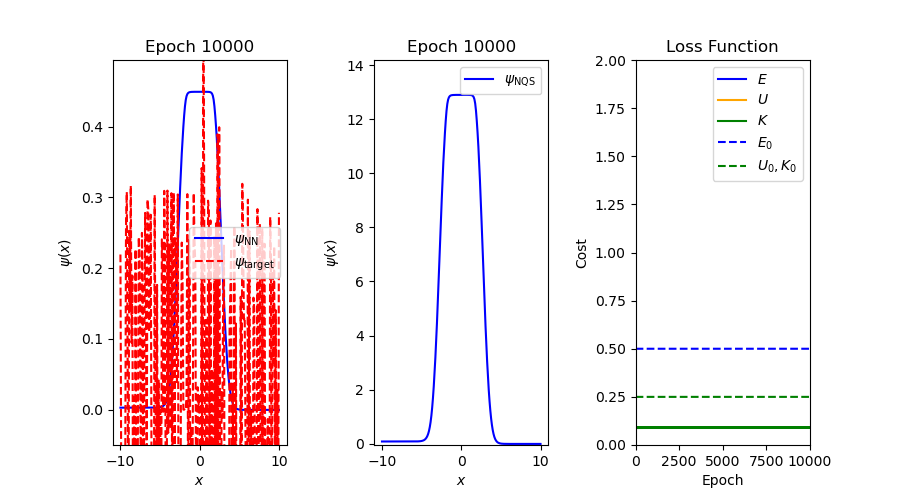

Training the NQS...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.37it/s]


In [171]:
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Cost")
ax3.set_ylim(0, 2)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)

# Training
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss0, U, K, psi, psi_normalized = loss_fn()    # Energy and \psi calculation
    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss0.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss_accum.append(loss0.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 100 == 0): # We plot periodically
        pic(i, Q_train, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.1)

E0, psi0 = loss_accum[-1], psi.clone().detach()

*Note: When running the above cell more than once, please take into account that the network is already trained from the first run. To restart the training from scratch, first re-run the code cells of sections [General parameters](#General-parameters), [The neural network](#The-neural-network) and [The optimizer](#The-optimizer).*

## Training the network: first excited state, $\ket{\psi_1}$

We now go for the first excited state. The process is almost identical to that of finding the ground-state wave function, with the fundamental difference that now the Rayleigh-Ritz theorem demands that

$$ \langle\psi_{\theta,0}|\psi_{\theta',1}\rangle = 0, $$

where $\psi_{\theta,0}, \psi_{\theta',1}$ are the ansatz wave functions of the ground and first excited state, respectively. A simple way to impose this condition is to make $\psi_1$ antisymmetric (given that $\psi_0$ is symmetric),

$$ \psi_{\theta',1}(x) \longleftarrow \psi_{\theta',1}(x)-\psi_{\theta',1}(-x) .$$

Notice that such symmetry considerations are valid for any system. (Any? No! A little redoubt of Gallic quantum systems fiercely stood their ground...)

In [9]:
def loss_fn_prime(E0, psi0):  
    psi = net1(X)-net1(-X)    
    psi2 = psi.pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    # Energy term
    N = h * psi2.sum()                       
    U = h * (1/2) * (X.pow(2) * psi2).sum() / N  
    K = h * (1/2) * dpsi_dx.pow(2).sum() / N              
    E = U + K   
    """
    # Overlap term
    num = (h * (psi*psi0).sum()).pow(2)
    den = (h * psi2.sum()) * (h * psi0.pow(2).sum())
    lambda_ = E.detach().pow(2)
    O = lambda_ * num / den
    """
    # Total loss
    L = E
    
    return L, U, K, psi, psi / torch.sqrt(N) 

Now we define a new neural network, which has the exact same architecture as the one used for the ground state. We can do this by creating a new instance of our [previous NQS](#The-neural-network). We also reset the optimizer parameters by redefining it. 

In [10]:
net1 = HarmonicNQS(W1, B, W2).to(device)
optimizer = torch.optim.RMSprop(params=net1.parameters(), lr=lr)

target = (1 / np.sqrt(2))*(np.pi**0.25)*torch.exp(-Q_train.pow(2) / 2)*Q_train

We define a new plotting function,

In [11]:
def pic(i, x, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    # Overlap
    ax1.set_title("Epoch {}".format(i+1))
    wf = psi_normalized.detach().numpy()
    if net1(torch.tensor([[-2.]])).item() > 0.: wf *= -1
    ax1.set_ylim(np.min(wf)*1.1, np.max(wf)*1.1)
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x.detach().numpy())
        ax1.lines[1].set_ydata(target.detach().numpy())
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NN}$', color='b')
        ax1.plot(x.detach().numpy(), target.detach().numpy(), linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend()
    
    # Wave function
    ax2.set_title("Epoch {}".format(i+1))
    wf = psi.detach().numpy()
    if net1(torch.tensor([[-2.]])).item() > 0.: wf *= -1
    ax2.set_ylim(np.min(wf)*1.1, np.max(wf)*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x.detach().numpy())
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x.detach().numpy(), wf, 
                 label='$\psi_\mathrm{NQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)+0.5, np.ones(i+1)-0.25][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)+0.5, linestyle='--', label='$E_0$', color='b')
        ax3.plot(x, np.ones(i+1)-0.25, linestyle='--', label='$U_0, K_0$', color='g')
        ax3.legend()
        
    fig.canvas.draw()

Now we are ready to train our ansatz $\psi_{\theta',1}=\langle x | \psi_{\theta',1}\rangle$.

<IPython.core.display.Javascript object>


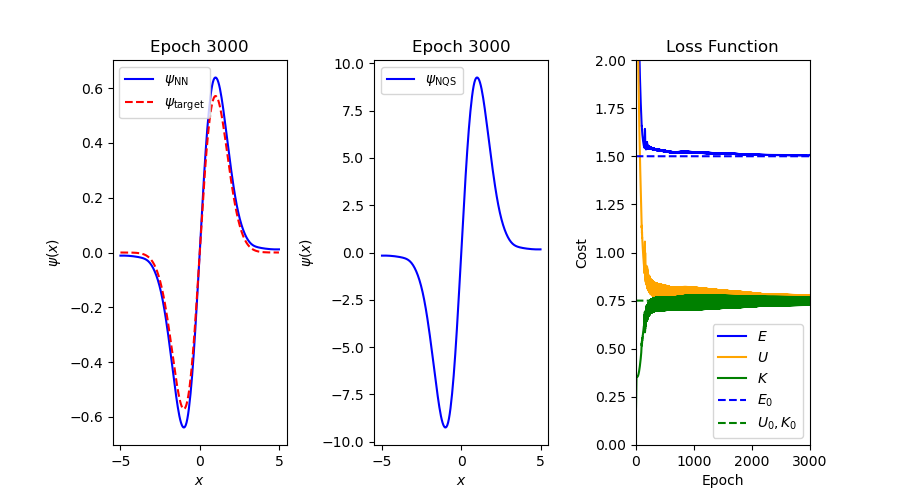

Training the NQS...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:09<00:00, 314.55it/s]


In [12]:
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Cost")
ax3.set_ylim(0, 2)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)

# Training
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss1, U, K, psi, psi_normalized = loss_fn_prime(E0, psi0)    # Energy and \psi calculation
    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss1.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss_accum.append(loss1.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 100 == 0): # We plot periodically
        pic(i, Q_train, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.1)
        
E1, psi1 = loss_accum[-1], psi

## Extra: Computation Graph

One might wish to visualize the actual graph computed by the ```autograd``` engine in the forward pass to convince oneself that everything is being properly computed. For that purpose, the Python library found at this [GitHub repository](https://github.com/szagoruyko/pytorchviz) can be used. 

Here we show an example of the graph generated during the training of the ground-state NQS, for the sake of simplicity.

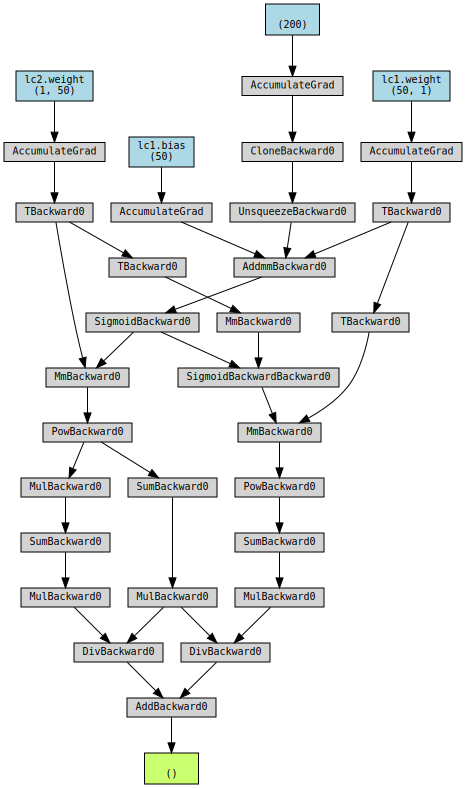

In [13]:
# Imports
from torchviz import make_dot 

make_dot(loss0, params=dict(list(net.named_parameters())))

The reader can easily check that, starting from the *leaves* of the tree (blue boxes at the top), all operations manually performed to these leave tensors appear in the graph in an ordered fashion. The graph additionally contains operations which are applied automatically by PyTorch, such as ```TBackward``` (transpose backward), which are necessary for the correct functioning of the code. 

The green box at the very bottom is called the *root* of the tree, and it represents the tensor w.r.t. which the gradients are computed, generally the loss function. 

Simply put, this purpose of this graph is to indicate to the ```autograd``` engine the order in which the chain rule is to be applied in the backpropagation of the error to the network parameters. Further explanations on this matter can fe bound at the official PyTorch site: [How Computational Graphs are Constructed in PyTorch](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/).

# Comments and extra stuff

We now go for the first excited state. The process is almost identical to that of finding the ground-state wave function, with the fundamental difference that now the Rayleigh-Ritz theorem demands that

$$ \langle\psi_{\theta,0}|\psi_{\theta',1}\rangle = 0, $$

where $\psi_{\theta,0}, \psi_{\theta',1}$ are the ansatz wave functions of the ground and first excited state, respectively. An obvious way to impose this condition is to add it to the loss function via a Lagrange multiplier:

$$ \mathcal{L'} = \frac{\bra{\psi_{\theta',1}}\hat{H}\ket{\psi_{\theta',1}}}{\langle\psi_{\theta',1}|\psi_{\theta',1}\rangle} + \lambda\frac{\langle\psi_{\theta,0}|\psi_{\theta',1}\rangle^2}{\langle\psi_{\theta',1}|\psi_{\theta',1}\rangle\langle\psi_{\theta,0}|\psi_{\theta,0}\rangle}, $$

where $\lambda$ is the Lagrange multiplier. In numerical processes it is important to balance the magnitudes of the different terms appearing in the loss at every epoch. In our case, we can do this by setting $\lambda=E_1^2$, where $E_1$ is the first term of the loss. 